# Analysis of the Diamond Market

In [183]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [149]:
#load the file into a dataframe
data = pd.read_csv('DiamondData.csv')
data.head

<bound method NDFrame.head of        carat        cut color clarity  depth  table    price     x     y     z
0       1.50       Fair     G     SI1   64.5   57.0  10352.0  7.15  7.09  4.59
1       0.70      Ideal     E     VS2   61.4   57.0   2274.0  5.72  5.78  3.53
2       1.22    Premium     G     VS1   61.3   58.0   8779.0  6.91  6.89  4.23
3       0.51    Premium     E     VS2   62.5   60.0   1590.0  5.08  5.10  3.18
4       2.02  Very Good     J     SI2   59.2   60.0  11757.0  8.27  8.39  4.91
...      ...        ...   ...     ...    ...    ...      ...   ...   ...   ...
49995   2.01    Premium     I     SI1   62.4   61.0  15707.0  8.01  7.99  4.99
49996   0.80    Premium     G      IF   62.6   58.0   4193.0  5.93  5.89  3.70
49997   0.90  Very Good     F     SI2   61.4   62.0   3770.0  6.11  6.20  3.78
49998   1.24      Ideal     F     SI2   61.4   58.0   6503.0  6.85  6.90  4.22
49999   0.70      Ideal     I    VVS1   61.4   55.0   2489.0  5.70  5.76  3.52

[50000 rows x 10 colu

## Cleaning the data

In [150]:
#remove all leading and trailing spaces in the data
data.columns = data.columns.str.strip()

In [151]:
#check if there are duplicates, if so remove them
dups = data.duplicated()

if dups.sum() == 0:
    print('There are no duplicates')
    
else:
    print('The number of duplicate rows: ', dups.sum())
    data = data.drop_duplicates()
    print('The duplicates have been dropped \n')
    print('New Data Shape: ', data.shape)

The number of duplicate rows:  115
The duplicates have been dropped 

New Data Shape:  (49885, 10)


In [152]:
#Print the number of missing values
print('Number of instances = %d\nNumber of attributes = %d' % (data.shape[0], data.shape[1]))
print('------------------------------')
data.isnull().sum()

Number of instances = 49885
Number of attributes = 10
------------------------------


carat        0
cut          0
color        0
clarity      0
depth      471
table      390
price      253
x          221
y          333
z          428
dtype: int64

In [153]:
#Since the price is the dependent variable, we will drop any rows that have a null value
data = data.dropna(axis = 'rows', subset = ['price'])
print('New Data Shape: ', data.shape)

New Data Shape:  (49632, 10)


In [154]:
#impute missing values with median
data = data.fillna(data.median())
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [155]:
#Find typos and categories of the non-integer groups
print('Breakdown of the non-integer 4 Cs')
print('\n', data.groupby('color').size())
print('\n', data.groupby('cut').size())
print('\n', data.groupby('clarity').size())

Breakdown of the non-integer 4 Cs

 color
D     6209
E     9004
F     8769
G    10419
H     7640
I     4999
J     2592
dtype: int64

 cut
Fair          1467
Good          4520
Ideal        19757
Premium      12745
Very Geod     2232
Very Good     8911
dtype: int64

 clarity
I1        688
IF       1650
SI1     12029
SI2      8412
VS1      7519
VS2     11320
VVS1     3359
VVS2     4655
dtype: int64


In [156]:
#Replace typo values with real values
data = data.replace('Very Geod', 'Very Good')
data.groupby('cut').size()

cut
Fair          1467
Good          4520
Ideal        19757
Premium      12745
Very Good    11143
dtype: int64

In [172]:
#Since cut, color, and clarity are ordinal, we can numerically place each value on a scale
#We will use a scale of: 
#0 - 6 for color (0 = J and 6 = D)
#0 - 4 for cut (0 = fair and 4 = Ideal)
#0 - 7 for clarity (0 = I1 and 7 = IF)

#color
data = data.replace('D', '6')
data = data.replace('E', '5')
data = data.replace('F', '4')
data = data.replace('G', '3')
data = data.replace('H', '2')
data = data.replace('I', '1')
data = data.replace('J', '0')

#cut
data = data.replace('Ideal', '4')
data = data.replace('Premium', '3')
data = data.replace('Very Good', '2')
data = data.replace('Good', '1')
data = data.replace('Fair', '0')

#clarity
data = data.replace('IF', '7')
data = data.replace('VVS1', '6')
data = data.replace('VVS2', '5')
data = data.replace('VS1', '4')
data = data.replace('VS2', '3')
data = data.replace('SI1', '2')
data = data.replace('SI2', '1')
data = data.replace('I1', '0')

## Discover outliers and eliminate them

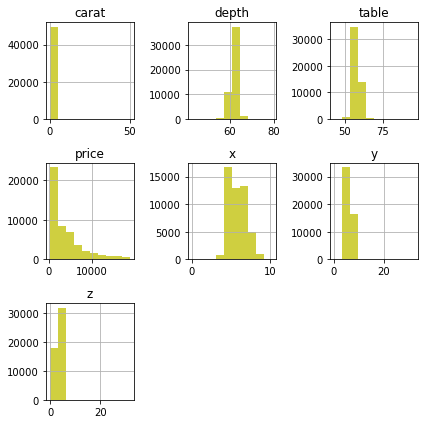

In [157]:
#Histogram of numerical values
data[['carat', 'depth', 'table', 'price', 'x', 'y','z']].hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

<AxesSubplot:>

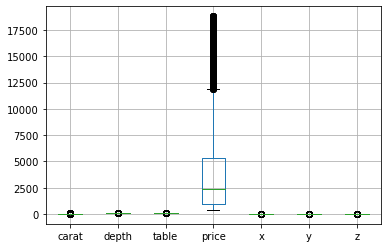

In [159]:
data.boxplot()

<AxesSubplot:>

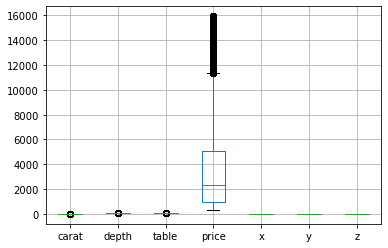

In [161]:
#Eliminate Outliers using a Standard Deviation model
for colName in data.columns:
    if data[colName].dtype == 'float64':
        mean = np.mean(data[colName])
        stdev = np.std(data[colName])
        cutoff = 3*stdev #using 3 standard deviations for outliers
        lower_range = mean - cutoff
        upper_range = mean + cutoff
        data = data[(data[colName] < upper_range) & (data[colName] > lower_range)]
        

#Graph a boxplot to visualize outliers 
data.boxplot()

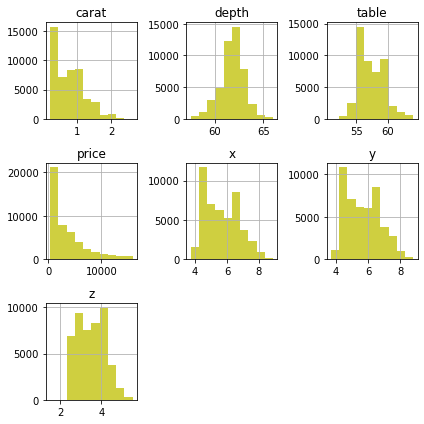

In [162]:
#Histogram of numerical values
data[['carat', 'depth', 'table', 'price', 'x', 'y','z']].hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

In [170]:
#Determine the correlations of each numerical feature
corr = data.corr()
corr

,carat,depth,table,price,x,y,z
carat,1.000000,0.024635,0.186390,0.923427,0.979071,0.977000,0.976122
depth,0.024635,1.000000,-0.278981,-0.002870,-0.024448,-0.027039,0.086871
table,0.186390,-0.278981,1.000000,0.132597,0.193324,0.188575,0.159230
price,0.923427,-0.002870,0.132597,1.000000,0.890439,0.890609,0.886040
x,0.979071,-0.024448,0.193324,0.890439,1.000000,0.993214,0.986397
y,0.977000,-0.027039,0.188575,0.890609,0.993214,1.000000,0.984905
z,0.976122,0.086871,0.159230,0.886040,0.986397,0.984905,1.000000


Price has the strongest correlation with carat and the x, y, and z dimensions. Carat also has a strong positive correlation with the x, y, and z dimnesions, likely because, as the weight of the diamond increases, so does the general size. Overall, the depth and table have very weak correlation with any of the other features except for each other; which is a weak negative correlation.

In [173]:
data.describe()

,carat,depth,table,price,x,y,z
count,47495.000000,47495.000000,47495.000000,47495.000000,47495.000000,47495.000000,47495.000000
mean,0.765601,61.750418,57.377374,3627.273797,5.668691,5.671593,3.502008
std,0.433677,1.264338,2.099031,3490.491000,1.065867,1.057574,0.656712
min,0.200000,57.500000,51.000000,326.000000,3.730000,3.680000,1.530000
25%,0.390000,61.100000,56.000000,928.000000,4.690000,4.700000,2.900000
50%,0.700000,61.800000,57.000000,2318.000000,5.670000,5.680000,3.510000
75%,1.020000,62.500000,59.000000,5094.000000,6.490000,6.490000,4.010000
max,2.630000,66.000000,64.000000,15934.000000,8.880000,8.810000,5.510000


## Multiple Regression Analysis 

In [219]:
X = data[['carat','cut','clarity','color','depth','table','x','y','z']]
y = np.array(data['price'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [220]:
model = LinearRegression()
clf = model.fit(X,y)
print('Coefficient: ', clf.coef_)

Coefficient:  [10787.01461097    90.09990056   460.8471623    299.13652369
   -35.64996544   -26.22729893  -728.16719977    18.76472428
  -438.41278547]


In [221]:
predictions = model.predict(X)
rmse = mean_squared_error(y, predictions, squared = False)
print('RMSE: ', rmse)

RMSE:  1023.5415598557569


The RMSE is lower than the price standard deviation, which means the model between carat and price is predicting some of the variability in price. 

ValueError: x and y must be the same size

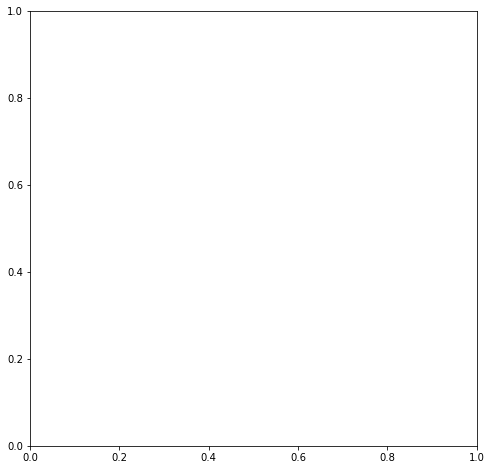

In [209]:
plt.scatter(x,y)
plt.plot(x, predictions)

In [223]:
plt.scatter(data['carat'])

TypeError: scatter() missing 1 required positional argument: 'y'